In [1]:
import caffe
import numpy as np
from __future__ import print_function

In [2]:
def log_progress(sequence, title='', every=1, size=None, end_msg='', removeAtTheEnd=False):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{title} : {value} ({index} / {size})'.format(
                        title=title,
                        value=sequence[index-1],
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = end_msg
        if removeAtTheEnd:
            box.close()
    

In [3]:
ICIPpath = '/home/jogue/workspace/ICIPmodels/'
weights_path_fuse='/home/jogue/workspace/ICIPmodels/fuse_weights.caffemodel'
weights_path_fuse_record='/home/jogue/workspace/ICIPmodels/fuse_weights_pseudoTraining.caffemodel'
fuse_deploy = ICIPpath + 'fuse_train_val.prototxt'

In [4]:
caffe_gpu = True
if not caffe_gpu:
    caffe.set_mode_cpu()
else:
    caffe.set_mode_gpu()
    caffe.set_device(0);

In [5]:
fuseNet = caffe.Net(fuse_deploy,weights_path_fuse, caffe.TRAIN)

In [6]:
fuseBlobs = [(k, v.data.shape) for k, v in fuseNet.blobs.items()]
fuseLayers = [(k, v[0].data.shape, v[1].data.shape) for k, v in fuseNet.params.items() if k not in ['upscore37_data0','upscore37_data1','upscore_sum', 'upscore_concat','upscore_rc_corrected']]

In [7]:
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("fuseBlobs")
for a in fuseBlobs:
    print(a)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("fuseLayers")
for a in fuseLayers:
    print(a)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fuseBlobs
('data0', (1, 3, 427, 561))
('label', (1, 1, 427, 561))
('label_label_0_split_0', (1, 1, 427, 561))
('label_label_0_split_1', (1, 1, 427, 561))
('label_label_0_split_2', (1, 1, 427, 561))
('label_label_0_split_3', (1, 1, 427, 561))
('label_label_0_split_4', (1, 1, 427, 561))
('label_label_0_split_5', (1, 1, 427, 561))
('label_label_0_split_6', (1, 1, 427, 561))
('label_label_0_split_7', (1, 1, 427, 561))
('label_label_0_split_8', (1, 1, 427, 561))
('label_label_0_split_9', (1, 1, 427, 561))
('label_label_0_split_10', (1, 1, 427, 561))
('label_label_0_split_11', (1, 1, 427, 561))
('label_label_0_split_12', (1, 1, 427, 561))
('label_label_0_split_13', (1, 1, 427, 561))
('label_label_0_split_14', (1, 1, 427, 561))
('data1', (1, 3, 427, 561))
('conv1_1_data0', (1, 64, 625, 759))
('conv1_2_data0', (1, 64, 625, 759))
('pool1_data0', (1, 64, 313, 380))
('conv2_1_data0', (1, 128, 313, 380))
('conv2_2_data0', (1, 128,

In [8]:
fuseLayers = ['score_fused_concat','score_concat_rc_conv1','score_concat_rc_conv3','score_concat_rc_conv5']

In [9]:
results = {}
results['accuracy_concat'] = []
results['accuracy_data0'] = []
results['accuracy_data1'] = []
results['accuracy_rc'] = []
results['accuracy_sum'] = []
results['loss_concat'] = []
results['loss_data0'] = []
results['loss_data1'] = []
results['loss_rc'] = []
results['loss_sum'] = []

In [31]:
lr = 0.00001
for iii in log_progress(range(795),title='Iteration', end_msg='Finished !'): 
    fuseNet.forward()       
    fuseNet.backward()
    for key in fuseLayers:
        fuseNet.params[key][0].data[:] -= lr * fuseNet.params[key][0].diff[:]
        fuseNet.params[key][1].data[:] -= lr * fuseNet.params[key][1].diff[:]
    for output in fuseNet.outputs:
        results[output].append(float(fuseNet.blobs[output].data[...]))
    if iii%795==0:
        lr=0.1*lr
    

KeyboardInterrupt: 

In [11]:
#np.savez('/home/jogue/workspace/ICIPmodels/results.npz',results)

In [12]:
fuseNet.save(weights_path_fuse_record)

In [16]:
results.keys()

['loss_data0',
 'loss_concat',
 'loss_sum',
 'accuracy_sum',
 'loss_rc',
 'accuracy_data0',
 'accuracy_data1',
 'loss_data1',
 'accuracy_rc',
 'accuracy_concat']

In [35]:
len(results['accuracy_data1'][-796-57:-1-57])

795

In [37]:
print('accuracy_data0',sum(results['accuracy_data0'][-796-57:-1-57])/795)
print('accuracy_data1',sum(results['accuracy_data1'][-796-57:-1-57])/795)
print('accuracy_sum',sum(results['accuracy_sum'][-796-57:-1-57])/795)
print('accuracy_concat',sum(results['accuracy_concat'][-796-57:-1-57])/795)
print('accuracy_rc',sum(results['accuracy_rc'][-796-57:-1-57])/795)

accuracy_data0 0.661308959876
accuracy_data1 0.683726655631
accuracy_sum 0.701114028767
accuracy_concat 0.666797254239
accuracy_rc 0.628986761705


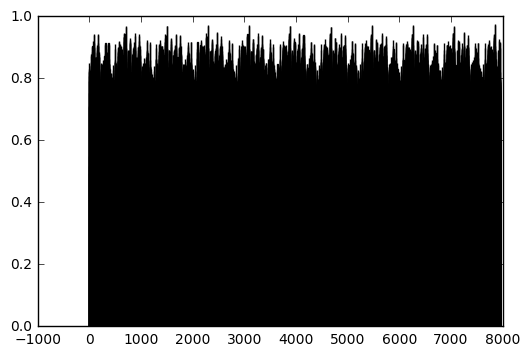

In [26]:
import matplotlib.pyplot as plt
D = results['accuracy_sum']
plt.bar(range(len(D)), D, align='center')
D = results['accuracy_data0']
plt.bar(range(len(D)), D, align='center')
D = results['accuracy_data1']
plt.bar(range(len(D)), D, align='center')

plt.show()

In [38]:
JORIS : faire un test net GPU des deux pipelines sans  fusion et un TRAIN net GPU de la fusion only ça se trouve ça passe !!!

SyntaxError: invalid syntax (<ipython-input-38-7a49b08bb6d9>, line 1)